#Twitter Geolocation Prediction using Naïve Bayes

In [720]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [721]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
import csv
import os
import pandas as pd
import numpy as np 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, median_absolute_error

## Reading the Dataset

In [722]:
#read the path
file_path = "data.csv"

df = pd.read_csv(file_path)

In [723]:
df.head()

,user_id,created_at,tweet_id,text,country
0,1.294095e+18,2022-11-22T22:13:48.000Z,1.595179e+18,RT @JonnyCaplan: Creative Entrepreneur of the ...,USA
1,1.294095e+18,2022-11-22T20:33:39.000Z,1.595154e+18,RT @JoseMarky_200: @shirtsthtgohard Available ...,USA
2,1.294095e+18,2022-11-22T19:14:08.000Z,1.595134e+18,RT @moyo_world: We're moving our manufacturing...,USA
3,1.294095e+18,2022-11-22T16:56:17.000Z,1.595099e+18,RT @winwinbank: 🏆Dünya Kupasında Da Güvenin Ad...,USA
4,1.294095e+18,2022-11-22T15:05:37.000Z,1.595071e+18,RT @UtilityNet_: The Rules for the First Test ...,USA


In [724]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127333 entries, 0 to 127332
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     127333 non-null  float64
 1   created_at  127333 non-null  object 
 2   tweet_id    127333 non-null  float64
 3   text        127333 non-null  object 
 4   country     127333 non-null  object 
dtypes: float64(2), object(3)
memory usage: 4.9+ MB


Converting created_at from type object to pandas datetime format.

In [725]:
df['created_at'] = pd.to_datetime(df['created_at'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127333 entries, 0 to 127332
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   user_id     127333 non-null  float64            
 1   created_at  127333 non-null  datetime64[ns, UTC]
 2   tweet_id    127333 non-null  float64            
 3   text        127333 non-null  object             
 4   country     127333 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 4.9+ MB


Visualising Tweets Count Per Country

In [726]:
tweets_per_country = df['country'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

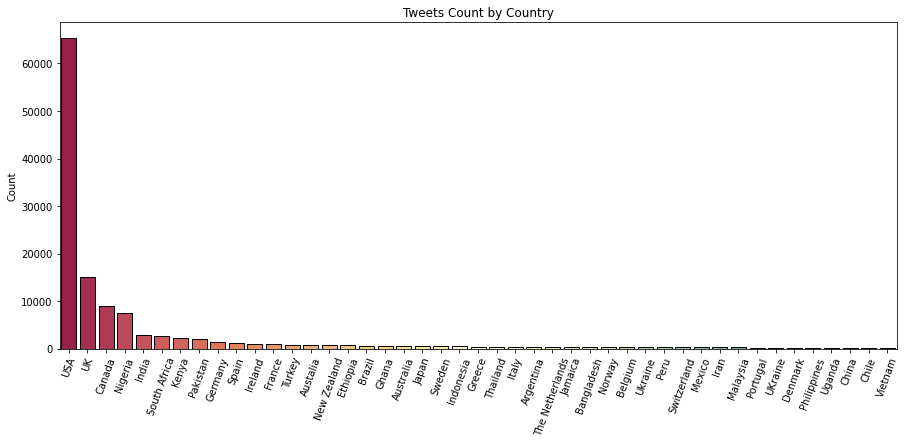

In [727]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets Count by Country')
plt.xticks(rotation=70)
plt.yticks()
plt.ylabel('Count')
plt.xlabel('')
plt.show()

We can see that USA significantly dominates all the other countries by Tweet counts.

## Preprocessing the Dataset

Due to an on-going World-Cup Event, I will not use **City/Country Names (CC)** as suggested in the paper. This is due to an overuse of many Country names to describe certain games.

**Location IndicativeWords (LIW)** won't be used either due to the lack of clarification.

###Creating #Hashtags (HASH) DataFrame

In [728]:
dfHASH = df.copy()

In [729]:
pattern = r'#\S+'

search = []    
for values in dfHASH['text']:
  hash = re.findall(pattern, values)
  search.append(hash)

dfHASH['hashtag'] = search

In [730]:
dfHASH.head()

,user_id,created_at,tweet_id,text,country,hashtag
0,1.294095e+18,2022-11-22 22:13:48+00:00,1.595179e+18,RT @JonnyCaplan: Creative Entrepreneur of the ...,USA,[]
1,1.294095e+18,2022-11-22 20:33:39+00:00,1.595154e+18,RT @JoseMarky_200: @shirtsthtgohard Available ...,USA,[]
2,1.294095e+18,2022-11-22 19:14:08+00:00,1.595134e+18,RT @moyo_world: We're moving our manufacturing...,USA,"[#Shenzhen, #ele…]"
3,1.294095e+18,2022-11-22 16:56:17+00:00,1.595099e+18,RT @winwinbank: 🏆Dünya Kupasında Da Güvenin Ad...,USA,"[#Marsbahis, #MarsBet]"
4,1.294095e+18,2022-11-22 15:05:37+00:00,1.595071e+18,RT @UtilityNet_: The Rules for the First Test ...,USA,"[#utility, #utilitynet, #BigData, #Analytics, ..."


In [731]:
dfHASH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127333 entries, 0 to 127332
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   user_id     127333 non-null  float64            
 1   created_at  127333 non-null  datetime64[ns, UTC]
 2   tweet_id    127333 non-null  float64            
 3   text        127333 non-null  object             
 4   country     127333 non-null  object             
 5   hashtag     127333 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 5.8+ MB


In [732]:
print("Number of Rows: " + str(len(dfHASH.index)))

Number of Rows: 127333


In [733]:
dfHASH = dfHASH.drop(columns=['user_id', 'created_at', 'tweet_id', 'text'])

In [734]:
dfHASH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127333 entries, 0 to 127332
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   country  127333 non-null  object
 1   hashtag  127333 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [735]:
dfHASH = dfHASH[dfHASH['hashtag'].map(lambda x: len(x)) > 0]

In [736]:
print("Number of Rows: " + str(len(dfHASH.index)))

Number of Rows: 20129


In [737]:
dfHASH.head()

,country,hashtag
2,USA,"[#Shenzhen, #ele…]"
3,USA,"[#Marsbahis, #MarsBet]"
4,USA,"[#utility, #utilitynet, #BigData, #Analytics, ..."
6,USA,"[#塔卡尔世界杯, #世界杯冠军预测, #足球, #开云, #真人百家乐]"
7,USA,"[#塔卡尔世界杯, #世界杯冠军预测, #足球, #开云, #真人百家乐]"


In [738]:
dfHASH = dfHASH.explode('hashtag')

In [739]:
dfHASH.head()

,country,hashtag
2,USA,#Shenzhen
2,USA,#ele…
3,USA,#Marsbahis
3,USA,#MarsBet
4,USA,#utility


###Creating @Mentions (MENT) DataFrame

In [740]:
dfMENT = df.copy()

In [741]:
pattern = r'@[^:\s]+'

search = []    
for values in dfMENT['text']:
  ment = re.findall(pattern, values)
  search.append(ment)

dfMENT['mention'] = search

In [742]:
dfMENT.head()

,user_id,created_at,tweet_id,text,country,mention
0,1.294095e+18,2022-11-22 22:13:48+00:00,1.595179e+18,RT @JonnyCaplan: Creative Entrepreneur of the ...,USA,"[@JonnyCaplan, @The]"
1,1.294095e+18,2022-11-22 20:33:39+00:00,1.595154e+18,RT @JoseMarky_200: @shirtsthtgohard Available ...,USA,"[@JoseMarky_200, @shirtsthtgohard]"
2,1.294095e+18,2022-11-22 19:14:08+00:00,1.595134e+18,RT @moyo_world: We're moving our manufacturing...,USA,[@moyo_world]
3,1.294095e+18,2022-11-22 16:56:17+00:00,1.595099e+18,RT @winwinbank: 🏆Dünya Kupasında Da Güvenin Ad...,USA,[@winwinbank]
4,1.294095e+18,2022-11-22 15:05:37+00:00,1.595071e+18,RT @UtilityNet_: The Rules for the First Test ...,USA,[@UtilityNet_]


In [743]:
dfMENT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127333 entries, 0 to 127332
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   user_id     127333 non-null  float64            
 1   created_at  127333 non-null  datetime64[ns, UTC]
 2   tweet_id    127333 non-null  float64            
 3   text        127333 non-null  object             
 4   country     127333 non-null  object             
 5   mention     127333 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 5.8+ MB


In [744]:
print("Number of Rows: " + str(len(dfMENT.index)))

Number of Rows: 127333


In [745]:
dfMENT = dfMENT.drop(columns=['user_id', 'created_at', 'tweet_id', 'text'])

In [746]:
dfMENT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127333 entries, 0 to 127332
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   country  127333 non-null  object
 1   mention  127333 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [747]:
dfMENT = dfMENT[dfMENT['mention'].map(lambda x: len(x)) > 0]

In [748]:
print("Number of Rows: " + str(len(dfMENT.index)))

Number of Rows: 101771


In [749]:
dfMENT.head()

,country,mention
0,USA,"[@JonnyCaplan, @The]"
1,USA,"[@JoseMarky_200, @shirtsthtgohard]"
2,USA,[@moyo_world]
3,USA,[@winwinbank]
4,USA,[@UtilityNet_]


In [750]:
dfMENT = dfMENT.explode('mention')

In [751]:
dfMENT.head()

,country,mention
0,USA,@JonnyCaplan
0,USA,@The
1,USA,@JoseMarky_200
1,USA,@shirtsthtgohard
2,USA,@moyo_world


###Text Preprocessing

In [752]:
#remove rt from begining of sentence - do first cause RT is capitalized.

df["text"] = df["text"].map(lambda name: re.sub('^(RT)', ' ', name))

In [753]:
#removing links
df["text"] = df["text"].map(lambda name: re.sub(r'http\S+', ' ', name))

In [754]:
#removing mentions
df["text"] = df["text"].map(lambda name: re.sub("@([a-zA-Z0-9_]{1,50})", '', name))

In [755]:
#removing repeating characters
repeat_pattern = re.compile(r'(\w)\1*') #compile the pattern we are looking for
match_substitution = r'\1' #substituion pattern
df["text"] = df["text"].map(lambda name: re.sub(repeat_pattern, match_substitution, name))

In [756]:
#removal of digits with regex - we do this here because it is possible to have numbers in tags and urls replace with space.
df["text"] = df["text"].map(lambda name: re.sub(r'[0-9]', ' ', name))

In [757]:
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251" 
    "]+")
df["text"] = df["text"].map(lambda name: re.sub(EMOJI_PATTERN, ' ', name))

In [758]:
#making everything lowercase
df["text"] = df["text"].map(lambda name: name.lower())

In [759]:
special_pattern = re.compile('[!\.\^\$\|\?\*\+\=\(\)\{\}\@\=\/\<\>\,\~\`\-\%\&\:\;\[\]"“”…]')
df["text"] = df["text"].map(lambda name: re.sub(special_pattern, ' ', name))

In [760]:
#remove a hashtag if it has no significance, ie, not part of a #word
df["text"] = df["text"].map(lambda name: re.sub('(#[^(a-zA-Z0-9)])', ' ', name))

In [761]:
#removing doublicate spaces and all white spaces like \t, \n or \r
df["text"] = df["text"].map(lambda name: " ".join(name.split()))

In [762]:
#Now remove stop words
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

df["text"] = df["text"].map(lambda name: ' '.join([word for word in name.split() if word not in stopwords_dict]))

In [763]:
#After removing stop words we can clean up more
df["text"] = df["text"].map(lambda name: re.sub('[\']', ' ', name))

In [764]:
#remove all '#' characters
df["text"] = df["text"].map(lambda name: re.sub('#', ' ', name))

In [765]:
#final white space clean up
df["text"] = df["text"].map(lambda name: " ".join(name.split(' ')))

In [766]:
#still need to check for strings that contain whitespaces only and remove them
df["text"] = df["text"].map(lambda text: np.nan if len(text) == 0 else text)
df.dropna(axis=0, inplace=True)

In [767]:
df.dropna(axis=0, inplace=True)

In [768]:
dfTEXT = df.drop(columns=['user_id', 'created_at', 'tweet_id'])

In [769]:
dfTEXT.head()

,text,country
0,creative entrepreneur year shock last night gr...,USA
1,available guys,USA
2,we re moving manufacturing plant ‍ ‍ shenzhen ...,USA
3,dünya kupasında da güvenin adresi marsbahis ...,USA
4,rules first test mining utilitynet utility u...,USA


Getting rid of countries of low frequency

In [770]:
#Select number of countries that we want our model to examine (Top in # of tweets)
num_of_top_countries = 10
dfHASH = dfHASH[dfHASH["country"].isin(dfHASH["country"].value_counts()[:num_of_top_countries].index.values)]
dfMENT = dfMENT[dfMENT["country"].isin(dfMENT["country"].value_counts()[:num_of_top_countries].index.values)]
dfTEXT = dfTEXT[dfTEXT["country"].isin(dfTEXT["country"].value_counts()[:num_of_top_countries].index.values)]

##Building the Model Using BoW (Bag of Words) and Reporting Scores

In [771]:
model = MultinomialNB()

###MNB-HASH

In [772]:
corpus = dfHASH['hashtag']
print(corpus)

2                      #Shenzhen
2                          #ele…
3                     #Marsbahis
3                       #MarsBet
4                       #utility
                   ...          
127190                        #…
127194    #MotusWildlifeTracking
127204                    #fungi
127209                 #Shetland
127214                    #fungi
Name: hashtag, Length: 45540, dtype: object


In [773]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
Y = LabelEncoder().fit_transform(dfHASH['country'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

clf = model.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

print('Model Train Accuracy (score):', model.score(X_train, Y_train))
print('Model Test Accuracy (score):', model.score(X_test, Y_test))
print('Mean Absolute Error:', mean_absolute_error(Y_test, Y_predict))  
print('Median Absolute Error:', median_absolute_error(Y_test, Y_predict))
print("Accuracy: ", accuracy_score(Y_test, Y_predict))

Model Train Accuracy (score): 0.8108805445761967
Model Test Accuracy (score): 0.7902942468159859
Mean Absolute Error: 0.8407992973210364
Median Absolute Error: 0.0
Accuracy:  0.7902942468159859


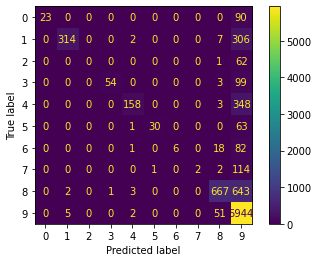

In [774]:
cm = confusion_matrix(Y_test, Y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

In [775]:
set(Y_test) - set(Y_predict)

{2}

This shows that 7 is never predicted.

MNB-MENT

In [776]:
corpus = dfMENT['mention']
print(corpus)

0             @JonnyCaplan
0                     @The
1           @JoseMarky_200
1         @shirtsthtgohard
2              @moyo_world
                ...       
127229         @StevieD131
127229           @Stewchat
127230           @Stewchat
127231       @MarcDavenant
127232     @connellyandrew
Name: mention, Length: 133179, dtype: object


In [777]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
Y = LabelEncoder().fit_transform(dfMENT['country'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

clf = model.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

print('Model Train Accuracy (score):', model.score(X_train, Y_train))
print('Model Test Accuracy (score):', model.score(X_test, Y_test))
print('Mean Absolute Error:', mean_absolute_error(Y_test, Y_predict))  
print('Median Absolute Error:', median_absolute_error(Y_test, Y_predict))
print("Accuracy: ", accuracy_score(Y_test, Y_predict))

Model Train Accuracy (score): 0.7267018950095266
Model Test Accuracy (score): 0.6989037393001952
Mean Absolute Error: 1.409520949091455
Median Absolute Error: 0.0
Accuracy:  0.6989037393001952


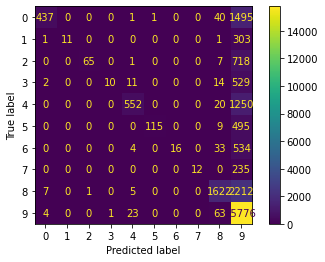

In [778]:
cm = confusion_matrix(Y_test, Y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

In [779]:
set(Y_test) - set(Y_predict)

set()

MNB-TEXT

In [780]:
corpus = dfTEXT['text']
print(corpus)

0         creative entrepreneur year shock last night gr...
1                                            available guys
2         we re moving manufacturing plant ‍ ‍ shenzhen ...
3         dünya kupasında da güvenin adresi  marsbahis  ...
4         rules first test mining utilitynet  utility  u...
                                ...                        
127228    seabirds breding gough island enjoyed excelent...
127229    wouldn’t mind left went least could stil make ...
127230                                                 left
127231    man walks towards stelworks hartlepol mcculin ...
127232    incredible moment suela braverman inadvertentl...
Name: text, Length: 102650, dtype: object


In [781]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
Y = LabelEncoder().fit_transform(dfTEXT['country'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

clf = model.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

print('Model Train Accuracy (score):', model.score(X_train, Y_train))
print('Model Test Accuracy (score):', model.score(X_test, Y_test))
print('Mean Absolute Error:', mean_absolute_error(Y_test, Y_predict))  
print('Median Absolute Error:', median_absolute_error(Y_test, Y_predict))
print("Accuracy: ", accuracy_score(Y_test, Y_predict))

Model Train Accuracy (score): 0.7304554310764735
Model Test Accuracy (score): 0.6661471018022406
Mean Absolute Error: 1.484072089624939
Median Absolute Error: 0.0
Accuracy:  0.6661471018022406


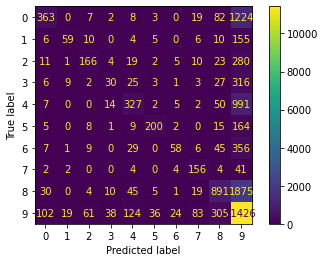

In [782]:
cm = confusion_matrix(Y_test, Y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

In [783]:
set(Y_test) - set(Y_predict)

set()